In [1]:
# Import modules 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
#nltk.download('stopwords')
#nltk.download('punkt')

In [2]:
%%markdown 
## Data wrangling 
The below part of data wrangling is explained extensively in the 'EDA' notebook.

## Data wrangling 
The below part of data wrangling is explained extensively in the 'EDA' notebook.


In [3]:
# Read data set
df = pd.read_csv('Job_Postings_US new.csv')

# Only select the 'Mid-Senior level', 'Entry level' and 'Internship' categories
df_new = pd.concat( [df[df.seniority_level == 'Mid-Senior level'], df[df.seniority_level == 'Entry level'], df[df.seniority_level == 'Internship']])

# Recode 'Entry level' and 'Internship' to 'Junior level'
df_new.replace({'seniority_level': {'Entry level': 'Junior level', 'Internship': 'Junior level'}}, inplace= True)

# Function to add feature TikTok_ind
def classify_company(row):
    if row['company_name'] == 'TikTok':
        return '1'
    else:
        return '0'
        
df_new['TikTok_ind'] = df_new.apply(classify_company, axis=1)

# Function to add feature Cali_ind
def classify_address_region(row):
    if row['company_address_region'] == 'California':
        return '1'
    elif row['company_address_region'] == 'CA':
        return '1'
    else:
        return '0'

df_new['Cali_ind'] = df_new.apply(classify_address_region, axis=1)

df_expanded = df_new.iloc[:,[0,1,2,3,10,4,9,5,6,7,8]]

# Model set before TF-IDF vectorizing
pre_model = df_expanded.loc[:,['ID', 'Cali_ind', 'TikTok_ind', 'job_description_text', 'seniority_level']]
pre_model


,ID,Cali_ind,TikTok_ind,job_description_text,seniority_level
1,1,1,0,Company DescriptionThe Ikigai platform unlocks...,Mid-Senior level
4,4,0,0,Job Title: Machine Learning EngineerLocation: ...,Mid-Senior level
21,21,0,0,About UsNational Grid is hiring a Senior Data ...,Mid-Senior level
22,22,0,0,About UsNational Grid is hiring a Senior Data ...,Mid-Senior level
23,23,0,0,About UsNational Grid is hiring a Senior Data ...,Mid-Senior level
...,...,...,...,...,...
965,965,0,0,What is Aviture?Aviture is a full-service tech...,Junior level
976,976,1,0,Location: US RemoteJob SummaryWe are seeking a...,Junior level
980,980,1,1,ResponsibilitiesThe Business Risk Integrated C...,Junior level
981,981,1,0,Location: US RemoteJob SummaryWe are seeking a...,Junior level


In [4]:
%%markdown
## Bigram and unigram analysis and removal
The 'EDA' notebook contains plots of the most occuring bigrams across both categories. It showed some common terms regardless of the label, 
think of 'machine learning', 'computer science' and 'data science'. Because the results of the first iteration of the model were no better than guessing 
I decide to add an additional step to the data preparation part: removal of bigrams and unigrams that frequently occur in both categories.<br>

To remove bigrams and unigrams:
- They had to be within 15% of each other. For instance, the bigram 'machine learning' occurred 1.304 times in junior level vacancies 
and 1.405 times in mid-senior level vacancies. In other words a difference of 7.2%. Thus I remove 'machine learning'.
- A bigram had to have a frequency of at least 25 in the mid-senior level category (and consequently of at least 20 in the junior level 
category because of the 15% difference). 

This means the removal of 63 bigrams and 325 unigrams.


## Bigram and unigram analysis and removal
The 'EDA' notebook contains plots of the most occuring bigrams across both categories. It showed some common terms regardless of the label, 
think of 'machine learning', 'computer science' and 'data science'. Because the results of the first iteration of the model were no better than guessing 
I decide to add an additional step to the data preparation part: removal of bigrams and unigrams that frequently occur in both categories.<br>

To remove bigrams and unigrams:
- They had to be within 15% of each other. For instance, the bigram 'machine learning' occurred 1.304 times in junior level vacancies 
and 1.405 times in mid-senior level vacancies. In other words a difference of 7.2%. Thus I remove 'machine learning'.
- A bigram had to have a frequency of at least 25 in the mid-senior level category (and consequently of at least 20 in the junior level 
category because of the 15% difference). 

This means the removal of 63 bigrams and 325 unigrams.


In [5]:
# see 'sources' for article in which this function appears 
def basic_clean(text):
  """
  A simple function to clean up the data. All the words that
  are not designated as a stop word is then lemmatized after
  encoding and basic regex parsing are performed.
  """
  stops = set(stopwords.words('english'))
  text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
  words = re.sub(r'[^\w\s]', '', text).split()
  return [word for word in words if word not in stops]

In [6]:
# All bigrams in 'Mid-Senior level' vacancies 
bigram_ms = pre_model[pre_model.seniority_level == 'Mid-Senior level']
words_ms = basic_clean(''.join(str(bigram_ms['job_description_text'].tolist())))

In [7]:
# All bigrams in 'Junior level' vacancies 
bigram_jr = pre_model[pre_model.seniority_level == 'Junior level']
words_jr = basic_clean(''.join(str(bigram_jr['job_description_text'].tolist())))

In [8]:
# function to compute percentage difference
def percentage_change(col1,col2):
    return abs((col2 - col1) / col1)

In [9]:
## Put all bigrams with their respective counts in a dataframe

# junior level vacancies 
bigram_count_jr = pd.DataFrame(pd.Series(nltk.ngrams(words_jr, 2)).value_counts().to_frame())
bigram_count_jr.reset_index(inplace = True)
bigram_count_jr.rename(columns={"count": "count_jr","index": "bigram_jr" }, inplace= True)

# mid-senior level vacancies 
bigram_count_ms = pd.DataFrame(pd.Series(nltk.ngrams(words_ms, 2)).value_counts().to_frame())
bigram_count_ms.reset_index(inplace = True)
bigram_count_ms.rename(columns={"count": "count_ms","index": "bigram_ms" }, inplace= True)

# merge dataframes and compute the percentual difference
bi_comp = pd.merge(bigram_count_jr, bigram_count_ms,  left_on = 'bigram_jr', right_on = 'bigram_ms')
bi_comp['diff_'] = percentage_change(bi_comp['count_ms'], bi_comp['count_jr']) 

In [10]:
bigrams_to_remove = list(bi_comp[(bi_comp.diff_ <=0.15) & (bi_comp.count_ms >= 25)].iloc[:,0])
print("Remove {} bigrams".format(len(bigrams_to_remove)))

Remove 63 bigrams


In [11]:
## Put all unigrams with their respective counts in a dataframe

# junior level vacancies
unigram_count_jr = pd.DataFrame(pd.Series(nltk.ngrams(words_jr, 1)).value_counts().to_frame())
unigram_count_jr.reset_index(inplace = True)
unigram_count_jr.rename(columns={"count": "count_jr","index": "unigram_jr" }, inplace= True)

# mid-senior level vacancies 
unigram_count_ms = pd.DataFrame(pd.Series(nltk.ngrams(words_ms, 1)).value_counts().to_frame())
unigram_count_ms.reset_index(inplace = True)
unigram_count_ms.rename(columns={"count": "count_ms","index": "unigram_ms" }, inplace= True)

# merge dataframes and compute the percentual difference
uni_comp = pd.merge(unigram_count_jr, unigram_count_ms,  left_on = 'unigram_jr', right_on = 'unigram_ms')
uni_comp['diff_'] = percentage_change(uni_comp['count_ms'], uni_comp['count_jr']) 

In [12]:
unigrams_to_remove = list(uni_comp[(uni_comp.diff_ <=0.15) & (uni_comp.count_ms >= 25)].iloc[:,0])
print("Remove {} unigrams".format(len(unigrams_to_remove)))

Remove 325 unigrams


In [13]:
# Function to remove the selected unigrams and bigrams
def clean_text(text):
    tokens = word_tokenize(text.lower())
    bigrams = list(ngrams(tokens, 2))

    # Remove unwanted unigrams
    tokens = [word for word in tokens if word not in unigrams_to_remove]

    # Remove unwanted bigrams
    filtered_tokens = []
    i = 0
    while i < len(tokens):
        if i < len(tokens) - 1 and (tokens[i], tokens[i+1]) in bigrams_to_remove:
            i += 2 # skip both words in the bigram
        else:
            filtered_tokens.append(tokens[i])
            i += 1

    return ' '.join(filtered_tokens)


In [14]:
# The variable 'desc_clean' contains the cleaned vacancies  
pre_model['desc_clean'] = pre_model['job_description_text'].apply(clean_text)
pre_model

,ID,Cali_ind,TikTok_ind,job_description_text,seniority_level,desc_clean
1,1,1,0,Company DescriptionThe Ikigai platform unlocks...,Mid-Senior level,company descriptionthe ikigai platform unlocks...
4,4,0,0,Job Title: Machine Learning EngineerLocation: ...,Mid-Senior level,job title : engineerlocation : remotewho we ar...
21,21,0,0,About UsNational Grid is hiring a Senior Data ...,Mid-Senior level,about usnational grid is hiring a senior data ...
22,22,0,0,About UsNational Grid is hiring a Senior Data ...,Mid-Senior level,about usnational grid is hiring a senior data ...
23,23,0,0,About UsNational Grid is hiring a Senior Data ...,Mid-Senior level,about usnational grid is hiring a senior data ...
...,...,...,...,...,...,...
965,965,0,0,What is Aviture?Aviture is a full-service tech...,Junior level,what is aviture ? aviture is a full-service te...
976,976,1,0,Location: US RemoteJob SummaryWe are seeking a...,Junior level,location : us remotejob summarywe are seeking ...
980,980,1,1,ResponsibilitiesThe Business Risk Integrated C...,Junior level,responsibilitiesthe business risk integrated c...
981,981,1,0,Location: US RemoteJob SummaryWe are seeking a...,Junior level,location : us remotejob summarywe are seeking ...


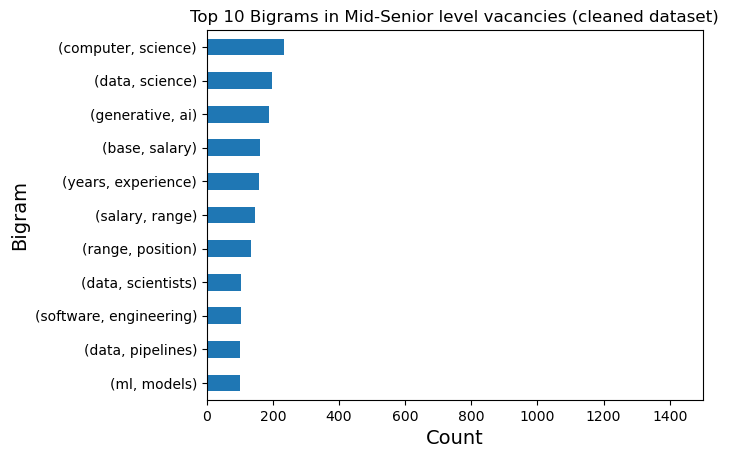

In [15]:
# All bigrams in 'Mid-Senior level' vacancies 
bigram_ms_adj = pre_model[pre_model.seniority_level == 'Mid-Senior level']
words_ms_adj = basic_clean(''.join(str(bigram_ms_adj['desc_clean'].tolist())))

# Plot the cleaned bigram list 
(pd.Series(nltk.ngrams(words_ms_adj, 2)).value_counts())[:11].sort_values().plot(kind= 'barh')
plt.xlabel('Count', fontsize = 14)
plt.ylabel('Bigram', fontsize = 14)
plt.xlim(0, 1500)
#plt.xticks(rotation = 75)
plt.title('Top 10 Bigrams in Mid-Senior level vacancies (cleaned dataset)')
plt.show()

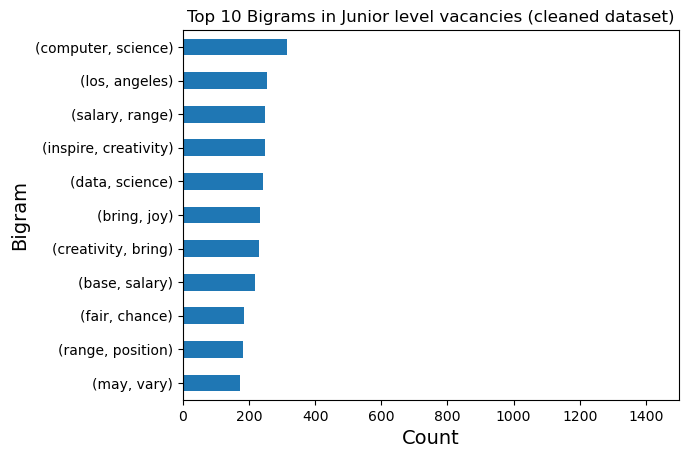

In [16]:
# All bigrams in 'Junior level' vacancies
bigram_jr_adj = pre_model[pre_model.seniority_level == 'Junior level']
words_jr_adj = basic_clean(''.join(str(bigram_jr_adj['desc_clean'].tolist())))

# Plot the cleaned bigram list 
(pd.Series(nltk.ngrams(words_jr_adj, 2)).value_counts())[:11].sort_values().plot(kind= 'barh')
plt.xlabel('Count', fontsize = 14)
plt.ylabel('Bigram', fontsize = 14)
plt.xlim(0, 1500)
#plt.xticks(rotation = 75)
plt.title('Top 10 Bigrams in Junior level vacancies (cleaned dataset)')
plt.show()


In [17]:
# Dataset to fit and score the model 
model_dataset = pre_model.iloc[:,[0,4,5]]
model_dataset.to_csv('model_dataset_att2.csv', index=False)

In [17]:
%%markdown
# Sources
https://medium.com/data-science/from-dataframe-to-n-grams-e34e29df3460

# Sources
https://medium.com/data-science/from-dataframe-to-n-grams-e34e29df3460
